In [11]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing

In [12]:
from libanalysis import PhantomAnalysis as pa
import phantom

In [13]:
all_end_dumps = []
for r,d,files in os.walk('..'):
    all_dumps = [os.path.join(r,f) for f in files if 'sgdisc_' in f]
    if all_dumps:
        all_end_dumps.append(sorted(all_dumps)[-1])

In [14]:
units = phantom.get_units()

In [15]:
units

{'udens': 5.94103125029151e-07,
 'udist': 14960000000000.0,
 'uerg': 8871227776136.363,
 'umass': 1.9891e+33,
 'utime': 5022728.790082334,
 'uvel': 2978460.6386750126,
 'yr': 0.1591606709661804}

In [34]:
def get_az_averaged_properties(disc,nbins=100,rmax=100):
    
    radii = np.sqrt(
             (disc.xyzh[0]-disc.ptmass_xyzmh[0,0])**2 + 
             (disc.xyzh[1]-disc.ptmass_xyzmh[1,0])**2 + 
             (disc.xyzh[2]-disc.ptmass_xyzmh[2,0])**2
            )
    
    rad_bins = np.linspace(0,rmax,nbins)
    ibins = np.digitize(radii,rad_bins)

    #Calculate temperatures from thermal energies
    kB = 1.38064852e-16    #erg / K
    mH = 1.6735575e-24    #grams
    gmw = 2.381           #mean mass taken from Phantom
    gamma = 5./3.         #barotropic index (NEED TO DOUBLE CHECK THIS)
    mstar = 1
    G = 6.67430e-8        # cgs grav constant
    
    out = {'r' : [],
           'npart': [],
           'omega': [],
           'temp': [],
           'sigma': [],
           'cs': [],
           'toomre': []
          }
        
    for i,rad in enumerate(rad_bins):
        # surface area of this radial bin
        bin_area = np.pi*(rad_bins[i]**2 - rad_bins[i-1]**2)
        bin_area_cgs = bin_area*units['udist']*units['udist']
        # mask for particles in this bin
        inbin = ibins==i
        # epicyclic frequency at this radial bin
        omega_cgs = np.sqrt(G*mstar*units['umass']/(rad*units['udist'])**3)
        # H = cs/Omega
        #H_cgs = spsound_cgs/omega_cgs
        
        # only want particles in disc midplane, defined as within 1AU of center
        midplane_mask = abs(disc.xyzh[2]-disc.ptmass_xyzmh[2,0])*units['udist'] < units['udist']
        wanted = inbin & midplane_mask
        
        # calc mean temperature, from phantom eos.f90
        temp_cgs = np.mean(mH*gmw*(gamma-1)*disc.utherm[wanted]*units['uerg']/kB)
        # density within this bin, from splash read_data_sphNG.f90
        rho_cgs = disc.massofgas*units['umass']/np.abs((disc.hfact/disc.xyzh[3,wanted])*units['udist'])**3
        sigma_cgs = sum(inbin)*disc.massofgas*units['umass']/bin_area_cgs
        # sigma = rho*2H
        #sigma_cgs_2 = np.mean(rho_cgs*2*H_cgs[wanted])
        
        # cs = RMS cs within annulus
        spsound2_cgs = gamma*(gamma-1)*disc.utherm*units['uerg'] # from phantom discplot.f90
        cs_cgs = np.sqrt(np.mean(spsound2_cgs[wanted]))
        # calc Q
        toomre = cs_cgs*omega_cgs/np.pi/sigma_cgs/G
        
        out['r'].append(rad)
        out['npart'].append(sum(wanted))
        out['omega'].append(omega_cgs)
        out['temp'].append(temp_cgs)
        out['sigma'].append(sigma_cgs)
        out['cs'].append(cs_cgs)
        out['toomre'].append(toomre)
    
    return out

In [35]:
def plot_results_in_grid(out_dict):
    fig,ax = plt.subplots(2,3,figsize=(20,10))
    i = 0
    j = 0
    for key, values in out_dict.items():
        if key == 'r':
            continue
        if i>2:
            i=0
            j+=1
        ax[j,i].plot(out_dict['r'],values)
        ax[j,i].set_title(key)
        i+=1
    plt.show()

../a1000/mdisc0.3/sgdisc_00022
/Users/s1863104/Documents/phd/phantom_runs/binarydiscs/useful_files


/Users/s1863104/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


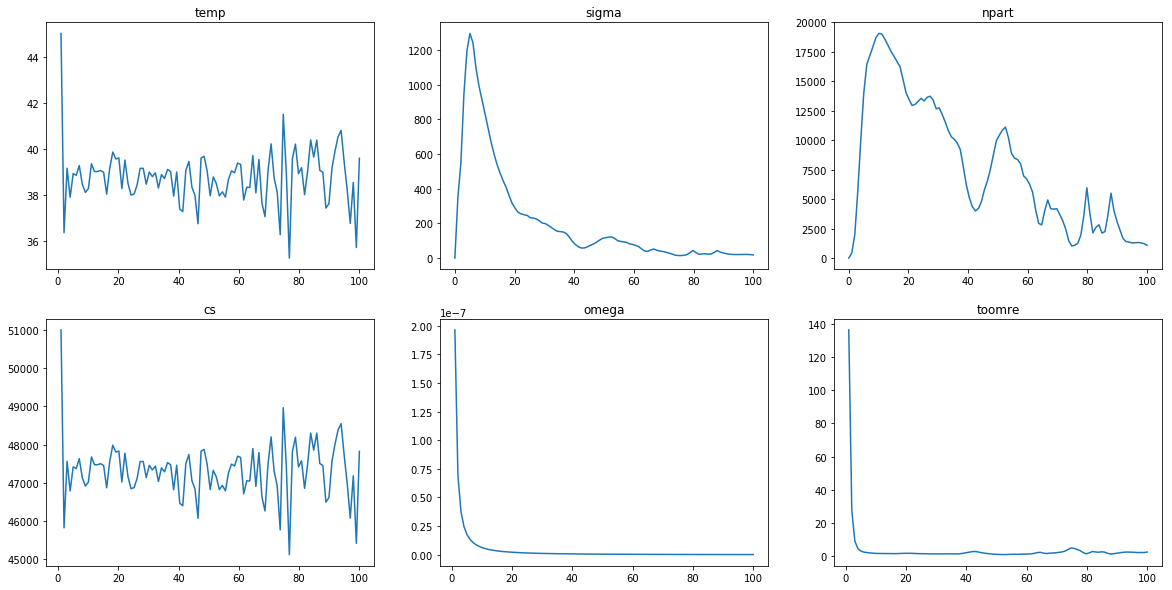

355.326794

In [37]:
from datetime import datetime

tstart = datetime.now()

dump = all_end_dumps[0]
print(dump)
disc = pa(dump)
out = get_az_averaged_properties(disc)
plot_results_in_grid(out)
    
tend = datetime.now()

(tend - tstart).total_seconds()